Number of valid impact links: 17
Number of temporal effect rows: 42


,event_id,indicator,date,effect_magnitude
0,EVT_0001,ACC_OWNERSHIP,2021-05-17,0.066667
1,EVT_0001,ACC_OWNERSHIP,2021-06-17,0.133333
2,EVT_0001,ACC_OWNERSHIP,2021-07-17,0.200000
3,EVT_0001,USG_TELEBIRR_USERS,2021-05-17,0.066667
4,EVT_0001,USG_TELEBIRR_USERS,2021-06-17,0.133333


indicator,ACC_4G_COV,ACC_MM_ACCOUNT,ACC_OWNERSHIP,AFF_DATA_INCOME,GEN_GAP_ACC,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_TELEBIRR_USERS
date,,,,,,,,,
2021-05-17,0.000000,0.0,0.066667,0.000000,0.0,0.0,0.0,0.066667,0.066667
2021-06-17,0.000000,0.0,0.133333,0.000000,0.0,0.0,0.0,0.133333,0.133333
2021-07-17,0.000000,0.0,0.200000,0.000000,0.0,0.0,0.0,0.200000,0.200000
2022-08-01,0.033333,0.0,0.000000,0.033333,0.0,0.0,0.0,0.000000,0.000000
2022-09-01,0.066667,0.0,0.000000,0.066667,0.0,0.0,0.0,0.000000,0.000000


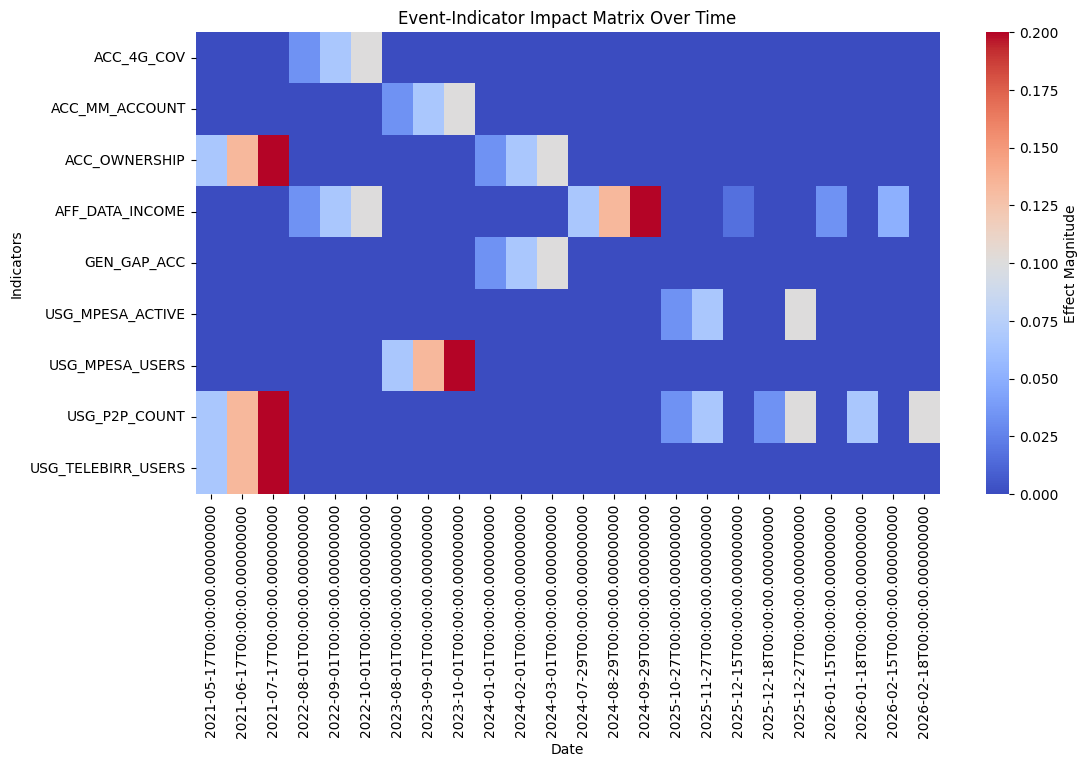

In [17]:
# ============================
# Task 3: Event Impact Modeling
# ============================

# 0. Imports
import pandas as pd
from pathlib import Path
from datetime import timedelta

# 1. Define paths
project_root = Path(r"C:\Users\THINKPAD\Desktop\10_Academy\Week_10\ethiopia-fi-forecast")
processed_data_folder = project_root / "data" / "processed"
enriched_file = processed_data_folder / "ethiopia_fi_unified_data_enriched.xlsx"

# 2. Load datasets
data = pd.read_excel(enriched_file, sheet_name="ethiopia_fi_unified_data", engine="openpyxl")
impact_links = pd.read_excel(enriched_file, sheet_name="Impact_sheet", engine="openpyxl")

# 3. Filter relevant columns and drop empty rows
impact_links = impact_links[[
    'parent_id', 'related_indicator', 'impact_direction', 
    'impact_magnitude', 'lag_months', 'observation_date'
]].dropna(subset=['related_indicator', 'impact_magnitude'])

print("Number of valid impact links:", len(impact_links))

# 4. Convert categorical magnitudes to numeric
magnitude_map = {"low": 0.05, "medium": 0.1, "high": 0.2}  # example mapping
impact_links['impact_magnitude_numeric'] = pd.to_numeric(
    impact_links['impact_magnitude'], errors='coerce'
)
impact_links['impact_magnitude_numeric'] = impact_links['impact_magnitude_numeric'].fillna(
    impact_links['impact_magnitude'].map(magnitude_map)
)

# 5. Define event start dates
# Use observation_date if available, otherwise fallback
impact_links['impact_start_date'] = pd.to_datetime(impact_links['observation_date'], errors='coerce')

# Drop rows with missing start dates
impact_links = impact_links.dropna(subset=['impact_start_date', 'impact_magnitude_numeric'])

# 6. Build temporal effects (3-month linear ramp-up by default)
expanded_rows = []
for _, row in impact_links.iterrows():
    for month_offset in range(3):  # assume 3-month effect
        effect_date = row['impact_start_date'] + pd.DateOffset(months=month_offset)
        magnitude = row['impact_magnitude_numeric'] * ((month_offset + 1)/3)  # linear ramp-up
        expanded_rows.append({
            'event_id': row['parent_id'],
            'indicator': row['related_indicator'],
            'date': effect_date,
            'effect_magnitude': magnitude
        })

temporal_effects = pd.DataFrame(expanded_rows)
print("Number of temporal effect rows:", len(temporal_effects))
display(temporal_effects.head())

# 7. Pivot to create event-indicator time series matrix
temporal_matrix = temporal_effects.pivot_table(
    index='date',
    columns='indicator',
    values='effect_magnitude',
    aggfunc='sum'
).fillna(0)

display(temporal_matrix.head())

# 8. Optional: visualize matrix as heatmap (requires seaborn)
try:
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,6))
    sns.heatmap(temporal_matrix.T, cmap='coolwarm', cbar_kws={'label': 'Effect Magnitude'})
    plt.title("Event-Indicator Impact Matrix Over Time")
    plt.ylabel("Indicators")
    plt.xlabel("Date")
    plt.show()
except ImportError:
    print("Seaborn not installed, skipping heatmap.")
